#### [ CNN Fashion MNIST MODEL]

[1] 모듈 로딩 및 데이터 준비<hr>

In [2]:
## 모듈 로딩
import torch                                        ## Tensor 및 기본 함수들 관련 모듈
import torch.nn as nn                               ## 인공신경망 관련 모듈
import torch.nn.functional as F # type: ignore
import torch.optim as optim 
from   torch.optim.lr_scheduler import ReduceLROnPlateau
from   torchmetrics.classification import *

from torchvision.datasets import FashionMNIST       ## 비젼관련 내장 데이터셋 모듈
from torch.utils.data import DataLoader             ## Pytorch의 데이터셋 관련 모듈
from torchinfo import summary                       ## 모델 구조 및 정보 확인 모듈

import torchvision.transforms as transforms         ## 비젼관련 이미지 증강/변환 관련 모듈

import matplotlib.pyplot as plt                     ## 이미지 시각화 


In [41]:
## 이미지 관련 준비
IMG_ROOT = '../data/image/'                         ## 이미지 데이터 저장 폴더 경로


[2] 데이터 로딩 <hr>

In [42]:
## 내장 데이터셋 로딩
trainDS=FashionMNIST(root=IMG_ROOT,
                     download=True,
                     train=True,
                     transform=transforms.ToTensor())

In [43]:
testDS=FashionMNIST(root=IMG_ROOT,
                     download=True,
                     train=False, 
                     transform=transforms.ToTensor())

In [44]:
## 데이터셋 체크
## - 타입
print(f'type         : {type(testDS)}')

## - 속성 : 클래스 정보
print(f'classes      : {testDS.classes}')
print(f'class_to_idx : {testDS.class_to_idx}')

type         : <class 'torchvision.datasets.mnist.FashionMNIST'>
classes      : ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_to_idx : {'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


In [45]:
## - 속성 : 데이터와 타겟
print(f'targets      : {testDS.targets} {len(trainDS.classes)}')
print(f'data         : {testDS.data.shape}')


targets      : tensor([9, 2, 1,  ..., 8, 1, 5]) 10
data         : torch.Size([10000, 28, 28])


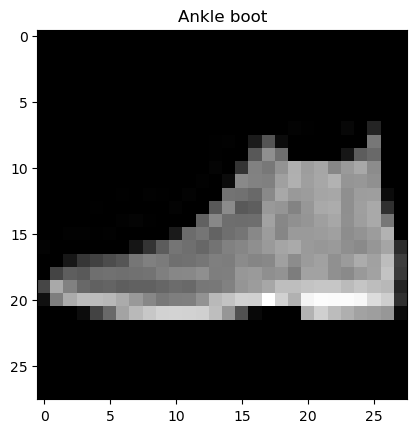

In [46]:
## 이미지 데이터와 타겟 확인
idx_to_classes ={v:k for k, v in testDS.class_to_idx.items()}

plt.imshow(testDS.data[0], cmap='gray')
plt.title(idx_to_classes[testDS.targets[0].item()])
plt.show()

[3] 모델 정의 및 설계 <hr>

In [47]:
## DNN MODEL -----------------------------------------------------------------------
## 클래스이름 : FashionDNN
## 부모클래스 : nn.Module
## 모델구현법 : 지도학습 + 다중 분류 
## 모델층 구성  입력피쳐/신호     출력/퍼셉트론수    활성화함수
## 입  력  층       784             512             ReLu
## 은  닉  층       512             256             ReLu
## 은  닉  층       256             130             ReLu
## 출  력  층       130             10               X
## ----------------------------------84----------------------------------------------
class FashionDNN(nn.Module):
    def __init__(self, isDebug=False):
        super().__init__()
        self.in_layer   = nn.Flatten()
        self.hd_layer1  = nn.Linear(784, 512)
        self.drop_layer = nn.Dropout(0.25)
        self.hd_layer2  = nn.Linear(512, 256)
        self.hd_layer3  = nn.Linear(256, 130)
        self.out_layer  = nn.Linear(130, 10)
        self.isDebug    = isDebug
        
    ## 순방향 학습 진행 메서드 
    def forward(self, data):
        ## 3D (BS, H, W) ==> 2D (BS, H*W)
        if self.isDebug: print(f'data shape : {data.shape}')
        out = self.in_layer(data)
        if self.isDebug: print(f'out shape : {out.shape}')

        out =F.relu(self.hd_layer1(out))
        out = self.drop_layer(out)

        out =F.relu(self.hd_layer2(out))
        out = self.drop_layer(out)

        out =F.relu(self.hd_layer3(out))
        out = self.out_layer(out)
        
        if self.isDebug: print(f'out shape : {out.shape}')
        return out

[4] 학습 준비 <hr>

In [ ]:
## 학습 설정
EPOCHS      = 10
BATCH_SIZE  = 100
T_ITERATION = int(trainDS.data.shape[0]/BATCH_SIZE)
V_ITERATION = int(testDS.data.shape[0]/BATCH_SIZE)

# 최적화 설정
LR          = 0.001                    # w,b 업데이터 간격 조절 
PAT_CNT     = 10                       # 10번 참을게 ㅎㅎㅎ
CLASSES     = len(trainDS.classes)

# 학습 및 데이터 로딩 실행 위치/저장 위치
DEVICE      = 'gpu' if torch.cuda.is_available() else 'cpu'

In [ ]:
## 인스턴스 생성
GEN         = torch.Generator().manual_seed(42)
TRAINDL     = DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True, generator=GEN)
TESTDL      = DataLoader(testDS,  batch_size=BATCH_SIZE, shuffle=True, generator=GEN)

MODEL       = FashionDNN(True)
OPTIMIZER   = optim.Adam(MODEL.parameters(), lr=LR)
SCHEDULER   = ReduceLROnPlateau(OPTIMIZER, mode='min', patience=PAT_CNT)

# 클래스 라벨 반환 딕셔너리 
LOSS_FN     = nn.CrossEntropyLoss()
SCORE_FN    = MulticlassAccuracy(num_classes=CLASSES)

In [52]:
## 학습 관련 함수
## --------------------------------------------------------------
## - 검증 함수 : 테스트 또는 검증용 데이터셋 사용하는 함수 
##              W,b 업데이트 안함
## --------------------------------------------------------------
def evaluate(model, testDL, loss_fn, score_fn, n_iter):
    # 에포크 단위로 검증 => 검증 모드
    model.eval()

    # W, b가 업데이트 해제
    with torch.no_grad():
        T_LOSS, T_ACC = 0, 0
        for feature, target in testDL:
            # 학습 진행
            pre_y = model(feature)

            # 손실 계산
            loss = loss_fn(pre_y, target.reshape(-1).long())
            
            # 정확도 계산
            acc = score_fn(pre_y, target.reshape(-1))

            T_LOSS += loss.item()
            T_ACC  += acc.item()

    return T_LOSS/n_iter, T_ACC/n_iter
  

In [53]:
## 학습 관련 함수
## --------------------------------------------------------------
## - 학습 함수 : 학습 데이터셋 사용하는 함수 
##              W,b 업데이트 진행
## --------------------------------------------------------------
def training(model, trainDL, optimizer, loss_fn, score_fn, n_iter):
    # 학습 모드 설정
    model.train()

    E_LOSS, E_ACC = 0, 0
    for feature, target in trainDL:
        # 배치크기만큼 feature, target로딩

        # 가중치 기울기 0 초기화
        optimizer.zero_grad()

        # 학습 진행
        pre_y = model(feature)

        # 손실 계산
        loss = loss_fn(pre_y, target.reshape(-1).long())
        
        # 정확도 계산
        acc = score_fn(pre_y, target.reshape(-1))

        # 역전파 진행
        loss.backward()

        # 가중치/절편 업데이트
        optimizer.step()

        E_LOSS += loss.item()
        E_ACC  += acc.item()

    return E_LOSS/n_iter, E_ACC/n_iter

-> 학습 진행 

In [54]:
## 모델 경로 설정
MODEL_DIR  = './models/'
MODEL_FILE = 'fashionModel.pt'

In [ ]:
## 학습 관련 모듈 로딩
from utils import * 

# 에포크 : DS 처음부터 ~ 끝까지 학습  
HIST ={'Train':[[],[]], 'Valid':[[],[]]}  

# 모델 저장 위한 초기값
BEST_ACC = 0

# 조기 종료 위한 기준값 저장 변수 
EARLY_STOP = 3

# 에포크 단위 학습/검증 진행 
for epoch in range(EPOCHS):
    trainLoss, trainAcc = training(MODEL, TRAINDL, OPTIMIZER, LOSS_FN, SCORE_FN, T_ITERATION)
    validLoss, validAcc = evaluate(MODEL, TESTDL, LOSS_FN, SCORE_FN, V_ITERATION)
        
    # 모델 저장 / 모델 층별 가충치 / 바이어스 저장 
    if Best_ACC < validAcc:
        # torch.save(model, MODEL_DIR+MODEL_FILE)
        torch.save(MODEL, f'{MODEL_DIR}epoch{epoch+1}_Acc{validAcc:.3f}.pt')
        torch.save(MODEL.state_dict(), f'{MODEL_DIR}WandB.pt')
        Best_ACC = validAcc
        
    # 학습 상태 저장
    HIST['Train'][0].append(trainLoss) 
    HIST['Train'][1].append(trainAcc) 
    
    HIST['Valid'][0].append(validLoss) 
    HIST['Valid'][1].append(validAcc) 

    # 학습 상태 확인
    print(f'\nEPOCH[{epoch}/{EPOCHS}]----------------')
    print(f'- TRAIN_LOSS {trainLoss:.5f}  ACC {trainAcc:.5f}')
    print(f'- VALID_LOSS {validLoss:.5f}  ACC {validAcc:.5f}')
    
    # 조기 종료 체크 
    SCHEDULER.step(validLoss)
    
    # 참다가 결국 폭발....
    if SCHEDULER.num_bad_epochs >= SCHEDULER.patience:
        EARLY_STOP -= 1
        
    if not EARLY_STOP:
        print(f'{epoch+1}EPOCH : 성능 개선이 없어서 조기 종료합니다.')
  


EPOCH[0/10]----------------
- TRAIN_LOSS 0.57972  ACC 0.78766
- VALID_LOSS 0.45931  ACC 0.83012

EPOCH[1/10]----------------
- TRAIN_LOSS 0.40302  ACC 0.85334
- VALID_LOSS 0.39983  ACC 0.85274

EPOCH[2/10]----------------
- TRAIN_LOSS 0.36458  ACC 0.86678
- VALID_LOSS 0.38777  ACC 0.86192

EPOCH[3/10]----------------
- TRAIN_LOSS 0.34208  ACC 0.87512
- VALID_LOSS 0.37356  ACC 0.86700

EPOCH[4/10]----------------
- TRAIN_LOSS 0.32931  ACC 0.87820
- VALID_LOSS 0.34399  ACC 0.87623

EPOCH[5/10]----------------
- TRAIN_LOSS 0.31629  ACC 0.88275
- VALID_LOSS 0.35834  ACC 0.87226

EPOCH[6/10]----------------
- TRAIN_LOSS 0.30143  ACC 0.88899
- VALID_LOSS 0.33382  ACC 0.87890


KeyboardInterrupt: 

[7] 모델 활용 <hr>

In [ ]:
## 방법-1) 저장된 모델 로딩
model = torch.load(MODEL_DIR+'fashion_epoch8_0.899.pt', weights_only=False)
model

In [ ]:
## 방법-2) 저장된 층별 가중치와바이어스 로딩 
WEIGHTS_FILE = MODEL_DIR+'fashion_weights_epoch1_0.903.pt'

model2=FashionDNN()
states=torch.load(WEIGHTS_FILE, weights_only=True)
model2.load_state_dict(states)

In [4]:
target = torch.tensor([1, 1])
pre = torch.FloatTensor([[0.7, 0.1, 0.2], [0.3, 0.6, 0.1]])
pre_target = pre.argmax(axis=1)
pre, pre.argmax(axis=1), target, pre_target.eq(target)

(tensor([[0.7000, 0.1000, 0.2000],
         [0.3000, 0.6000, 0.1000]]),
 tensor([0, 1]),
 tensor([1, 1]),
 tensor([False,  True]))

- 예측함수 

In [ ]:
# 사용자 입력 데이터에 대한 전처리, 즉 모델에 입력되는 형태로 변환 
input_preprocessing = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

In [ ]:
# 이미지 식별 모델 연동 함수
from PIL import Image

def predictFashion(image_path):
    ## 모델 로딩
    model =torch.load(MODEL_FILE, weights_only=False)

    ## 이미지 전처리
    img_gray = Image.open(image_path).convert('L')
    imgTS    = input_preprocessing(img_gray)           # (C, H, W)      3D
    imgTS    = imgTS.unsqueeze(0)                      # (BS, C, H, W)  4D

    ## 예측 진행
    model.eval()
    with torch.no_grad(): pre_ = model(imgTS).argmax()
        
    return IDX_TO_CLASSES[pre_.item()]

In [ ]:
file='../data/image/boots_01.jpg'

predictFashion(file)

In [ ]:
def get_idx_to_classes(classes):
    return {v:k for k, v in classes}